# Part one

In [421]:
# import each library for assignment
import random
import numpy as np
import cmath
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt import solvers

solvers.options['show_progress']=False

In [422]:
# load and process data


def data_processing(N=1, part=0):

    if part==0:
        sample_X = np.loadtxt('./PA-1-data-text/polydata_data_sampx.txt')
        sample_Y = np.loadtxt('./PA-1-data-text/polydata_data_sampy.txt')
        poly_X = np.loadtxt('./PA-1-data-text/polydata_data_polyx.txt')
        poly_Y = np.loadtxt('./PA-1-data-text/polydata_data_polyy.txt')

        true_theta = np.loadtxt('./PA-1-data-text/polydata_data_thtrue.txt')
        print(sample_X.shape[0])
        sample_X = sample_X.reshape(1, sample_X.shape[0])
        sample_Y = sample_Y.reshape(sample_Y.shape[0], 1)

        poly_X = poly_X.reshape(1, poly_X.shape[0])
        poly_Y = poly_Y.reshape(poly_Y.shape[0], 1)
    else:
        sample_X = np.loadtxt('./PA-1-data-text/count_data_trainx.txt')
        sample_Y = np.loadtxt('./PA-1-data-text/count_data_trainy.txt')
        poly_X = np.loadtxt('./PA-1-data-text/count_data_testx.txt')
        poly_Y = np.loadtxt('./PA-1-data-text/count_data_testy.txt')

        sample_X = sample_X.reshape(sample_X.shape[0], sample_X.shape[1])
        sample_Y = sample_Y.reshape(sample_Y.shape[0], 1)

        poly_X = poly_X.reshape(poly_X.shape[0], poly_X.shape[1])
        poly_Y = poly_Y.reshape(poly_Y.shape[0], 1)
    
    # sample_X = sample_X.reshape(sample_X.shape[0], sample_X.shape[1])
    # sample_Y = sample_Y.reshape(sample_X.shape[1], 1)

    # poly_X = poly_X.reshape(poly_X.shape[0], poly_X.shape[1])
    # poly_Y = poly_Y.reshape(poly_X.shape[1], 1)

    return sample_X, sample_Y, poly_X, poly_Y

def Phi_2(Sample):
    return np.concatenate((Sample, Sample**2), axis=0)
    # return np.array( [ sample**k for k in range(k+1)]).reshape(k+1, 1)
    

# def Phi_2_mat(Sample, K):
#     print(Sample.shape)
#     return np.concatenate( ([Phi_2(S.reshape(Sample.shape[0],1)) for S in Sample.T]) ,axis=1)

#     # return np.array( [ sample**k for k in range(k+1)]).reshape(k+1, 1)
    

# def Phi_1_mat(Sample, K):
#     print(Sample.shape)
#     return np.concatenate( ([ S.reshape(Sample.shape[0],1) for S in Sample.T]) ,axis=1)        

# generate Phi(x).
def generate_Phix(X, K):
    return np.array( [ X**k for k in range(K+1)]).reshape(K+1, 1)

# generate Big Phi matrix dimen is (K, N).
def generate_Phi_mat(Sample, K, mode=0):
    if mode==0:
        return np.array( [generate_Phix(x, K) for x in Sample[0]])[:,:, (Sample.shape[0]-1)].T
    elif mode==1:
        return np.concatenate( ([ S.reshape(Sample.shape[0],1) for S in Sample.T]) ,axis=1)       
    else:
        return np.concatenate( ([Phi_2(S.reshape(Sample.shape[0],1)) for S in Sample.T]) ,axis=1)       

# Do the prediction though the fixed Theta.
def pred_polyY(polyX, Theta, mode=0):
    # Theta dim: (K+1, 1)
    Phi_mat_T = generate_Phi_mat(polyX, Theta.shape[0]-1, mode).T
    pred_Y = np.dot(Phi_mat_T, Theta)
    return pred_Y

In [427]:
# each model of regression 

def least_squares_Theta(SampleX, SampleY, K, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T)), np.dot(Phi_mat, SampleY))
    return Theta

def Regular_LS_Theta(SampleX, SampleY, K, lbda=0.1, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Theta = np.dot(np.linalg.inv(np.dot(Phi_mat, Phi_mat.T) + lbda * np.ones((Phi_mat.shape[0], Phi_mat.shape[0]))), np.dot(Phi_mat, SampleY))
    return Theta

def L1_LS_Theta(SampleX, SampleY, K, lbda=1, mode=0):
    # refer to the Problem Set 3.12
    # To solve Lasso, construct the matrix: 
    # X dimen:(2(K+1), 1), H dimen:(2(K+1), 2(K+1)), f dimen:(2(K+1), 1), G and h based on constraint dimen: (2(K+1), 2(K+1)), h (2(K+1), 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Phi_square = np.dot(Phi_mat, Phi_mat.T)
    Phi_y = np.dot(Phi_mat, SampleY)
    H_left = np.concatenate((Phi_square, -Phi_square), axis=0)
    H = np.concatenate( (H_left, -H_left), axis=1 )
    f = lbda*np.ones((H.shape[0], 1)) - np.concatenate( (Phi_y, -Phi_y), axis=0 )
    G = - np.identity(H.shape[0])
    h = np.zeros( (H.shape[0], 1) )
    Lasso_theta = solvers.qp(P=matrix(H), q=matrix(f), G=matrix(G), h=matrix(h))['x']
    Lasso_theta = np.matrix(Lasso_theta)
    # Lasso_theta is  [theta+, theta-]T, to get the theta = theta+ - theta-
    Theta = Lasso_theta[: int(H.shape[0]/2)] - Lasso_theta[ int(H.shape[0]/2):]
    Theta = np.array(Theta)
    return Theta
    
def Robust_LS(SampleX, SampleY, K, mode=0):
     # refer to the Problem Set 2.10
    # To solve Robust, construct the matrix: 
    # X dimen:((K+1) + N, 1), f dimen:((K+1) + N, 1), , A and b based on constraint dimen:(2N, (K+1) + N), b (2N， 1) matrix
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    f = np.concatenate((np.zeros((Phi_mat.shape[0], 1)), np.ones((SampleX.shape[1],1))), axis=0)
    A_left = np.concatenate( (-Phi_mat.T, Phi_mat.T), axis=0 )
    A_right = np.concatenate( (-np.identity(SampleX.shape[1]), -np.identity(SampleX.shape[1])), axis=0)
    A = np.concatenate( (A_left, A_right), axis=1 )
    b = np.concatenate((-SampleY, SampleY))
    Robust_theta = solvers.lp(G=matrix(A),c=matrix(f), h=matrix(b))['x']
    Theta = np.array(Robust_theta[: Phi_mat.shape[0]])
    return Theta

def Bayes_post(SampleX, SampleY, sigma_square, K, alpha=1, mode=0):
    Phi_mat = generate_Phi_mat(SampleX, K, mode=mode)
    Cov_mat = np.linalg.inv((1/alpha * np.identity((Phi_mat.shape[0])) + 1/sigma_square * np.dot(Phi_mat, Phi_mat.T)))
    Mu_theta = 1/(sigma_square)* np.dot(Cov_mat, np.dot(Phi_mat, SampleY) )
    return Mu_theta, Cov_mat

def Bayes_pred(Mu, Cov, PolyX, mode=0):
    # Mu dim (K+1, 1)
    Phi_mat = generate_Phi_mat(PolyX, Mu.shape[0]-1, mode=mode)
    pred = np.dot(Phi_mat.T, Mu)
    pred_var = np.dot(Phi_mat.T, np.dot(Cov, Phi_mat))
    std_var = np.sqrt(pred_var.diagonal())
    return pred, std_var


In [428]:
# utils for Part1

def hyperpara(samplex, sampley, x, y, K, model, mode=0):
    para = 0
    err = cmath.inf
    if model=='L1':
        para_list = np.linspace(0,1,20)
        for lbda in para_list:
            L1_theta = L1_LS_Theta(samplex, sampley, K, lbda, mode)
            pred = pred_polyY(x, L1_theta, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = lbda
    if model == 'RLS':
        para_list =  np.linspace(0,1,20)
        for lbda in para_list:
            RLS_theta = Regular_LS_Theta(samplex, sampley, K, lbda, mode)
            pred = pred_polyY(x, RLS_theta, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = lbda    
    if model == 'BR':
        para_list = np.linspace(0,5,50)
        for alpha in para_list:
            mu, cov = Bayes_post(samplex, sampley, 5, K, alpha, mode)
            pred, std = Bayes_pred(mu, cov, x, mode)
            mse = MSE(pred, y)
            if mse < err:
                err = mse
                para = alpha   
    return para


def MSE(pred, true):
    # L2 is sqrt(y1^2 + y2^2 .... yn^2)
    return np.linalg.norm(true-pred, ord=2)**2/len(pred)

def MAE(pred, true):
    return np.linalg.norm(true-pred, ord=1)/len(pred)


def seperate_data(data, ratio):
    r_len = ratio * len(data)
    np.random.shuffle(data)
    sample_x = data[:, 0].reshape(1, -1)[:, :int(r_len)]
    sample_y = data[:, 1].reshape(-1, 1)[:int(r_len), :]
    return sample_x, sample_y

In [321]:
# plot charts for a b

def plot_MSE_MAE(model, which='mse'):
    if which=='mse':
        plt.title('The MSE of Each Model')
    else:
        plt.title('The MAE of Each Model')
    plt.bar(model.keys(), model.values())
    plt.show()
    

def plot_each_model(samplex, sampley, X, pred_dict, Y, color_map):
    plt.figure(figsize=(15,20))

    ax1 = plt.subplot(321)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.scatter(X[0], pred_dict['LS'], c=color_map['LS'], label='LS',s=10)
    ax1.scatter(samplex[0], sampley, label='Samples',s=10)
    ax1.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax2 = plt.subplot(322)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.scatter(X[0], pred_dict['RLS'], c=color_map['RLS'], label='RLS', s=10)
    ax2.scatter(samplex[0], sampley, label='Samples',s=10)
    ax2.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax3 = plt.subplot(323)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.scatter(X[0], pred_dict['LASSO'], c=color_map['LASSO'], label='LASSO', s=10)
    ax3.scatter(samplex[0], sampley, label='Samples',s=10)
    ax3.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax4 = plt.subplot(324)
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.scatter(X[0], pred_dict['RR'], c=color_map['RR'], label='RR', s=10)
    ax4.scatter(samplex[0], sampley, label='Samples',s=10)
    ax4.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax5 = plt.subplot(325)
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    ax5.scatter(X[0], pred_dict['BR'], c=color_map['BR'], label='BR', s=10)
    ax5.scatter(X[0], pred_dict['BR_pos'], c=color_map['BR_pos'], label='BR_pos', s=10)
    ax5.scatter(X[0], pred_dict['BR_neg'], c=color_map['BR_neg'], label='BR_neg', s=10)
    ax5.scatter(samplex[0], sampley, label='Samples',s=10)
    ax5.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()
    plt.show()

 # plot chart for c
 # Plot the chart for pro C
def plot_probc_est(X, Y, model_dict):
    plt.figure(figsize=(17,10))

    ax1 = plt.subplot(321)
    # ls
    ax1.set_title('LS model')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax1.scatter(X[0], v['LS'], c=size_color_map[k], label=k, s=10)
    ax1.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax2 = plt.subplot(322)
    # RLS
    ax2.set_title('RLS model')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax2.scatter(X[0], v['RLS'], c=size_color_map[k], label=k, s=10)
    ax2.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax3 = plt.subplot(323)
    # LASSO
    ax3.set_title('LASSO model')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax3.scatter(X[0], v['LASSO'], c=size_color_map[k], label=k, s=10)
    ax3.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax4 = plt.subplot(324)
    # RR
    ax4.set_title('RR model')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'chocolate', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax4.scatter(X[0], v['RR'], c=size_color_map[k], label=k, s=10)
    ax4.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    ax5 = plt.subplot(325)
    # BR
    ax5.set_title('BR model')
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    size_color_map = {0.15:'brown', 0.25:'blue', 0.5:'green', 0.75:'pink', 1:'orange'}
    for k, v in model_dict.items():
        ax5.scatter(X[0], v['BR'], c=size_color_map[k], label=k, s=10)
    ax5.plot(X[0], Y, 'r-', label='True Value')
    plt.legend()

    # plt.subplots_adjust()
    plt.show()
    

def plot_std_size(ratio_list, model_mse):
    plt.figure(figsize=(10,10))
    plt.title('Each Model\'s MSE in each Ratio')
    plt.xlabel('Ratio')
    plt.ylabel('MSE')
    LS_list = []
    RLS_llist = []
    L1_list = []
    RR_list = []
    BR_list = []
    for k, v in model_mse.items():
        LS_list.append(v['LS'])
        RLS_llist.append(v['RLS'])
        L1_list.append(v['LASSO'])
        RR_list.append(v['RR'])
        BR_list.append(v['BR'])
    plt.plot(ratio_list, LS_list, color='brown', marker='*', label='LS')
    plt.plot(ratio_list, RLS_llist, color='blue', marker='*', label='RLS')
    plt.plot(ratio_list, L1_list, color='green', marker='*', label='LASSO')
    plt.plot(ratio_list, RR_list, color='pink', marker='*', label='RR')
    plt.plot(ratio_list, BR_list, color='orange', marker='*', label='BR')
    plt.legend()
    plt.show()   

# plot chart for d    

# Part 1 Problem a and b

50


c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


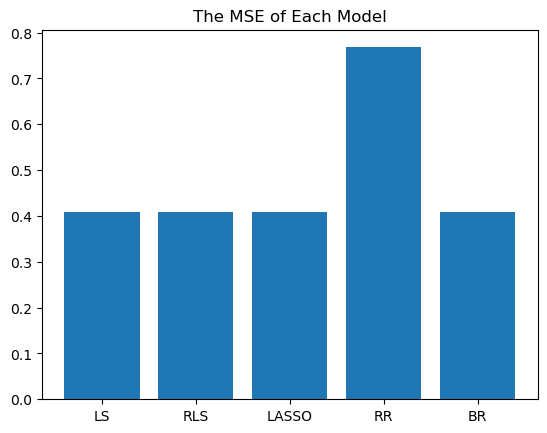

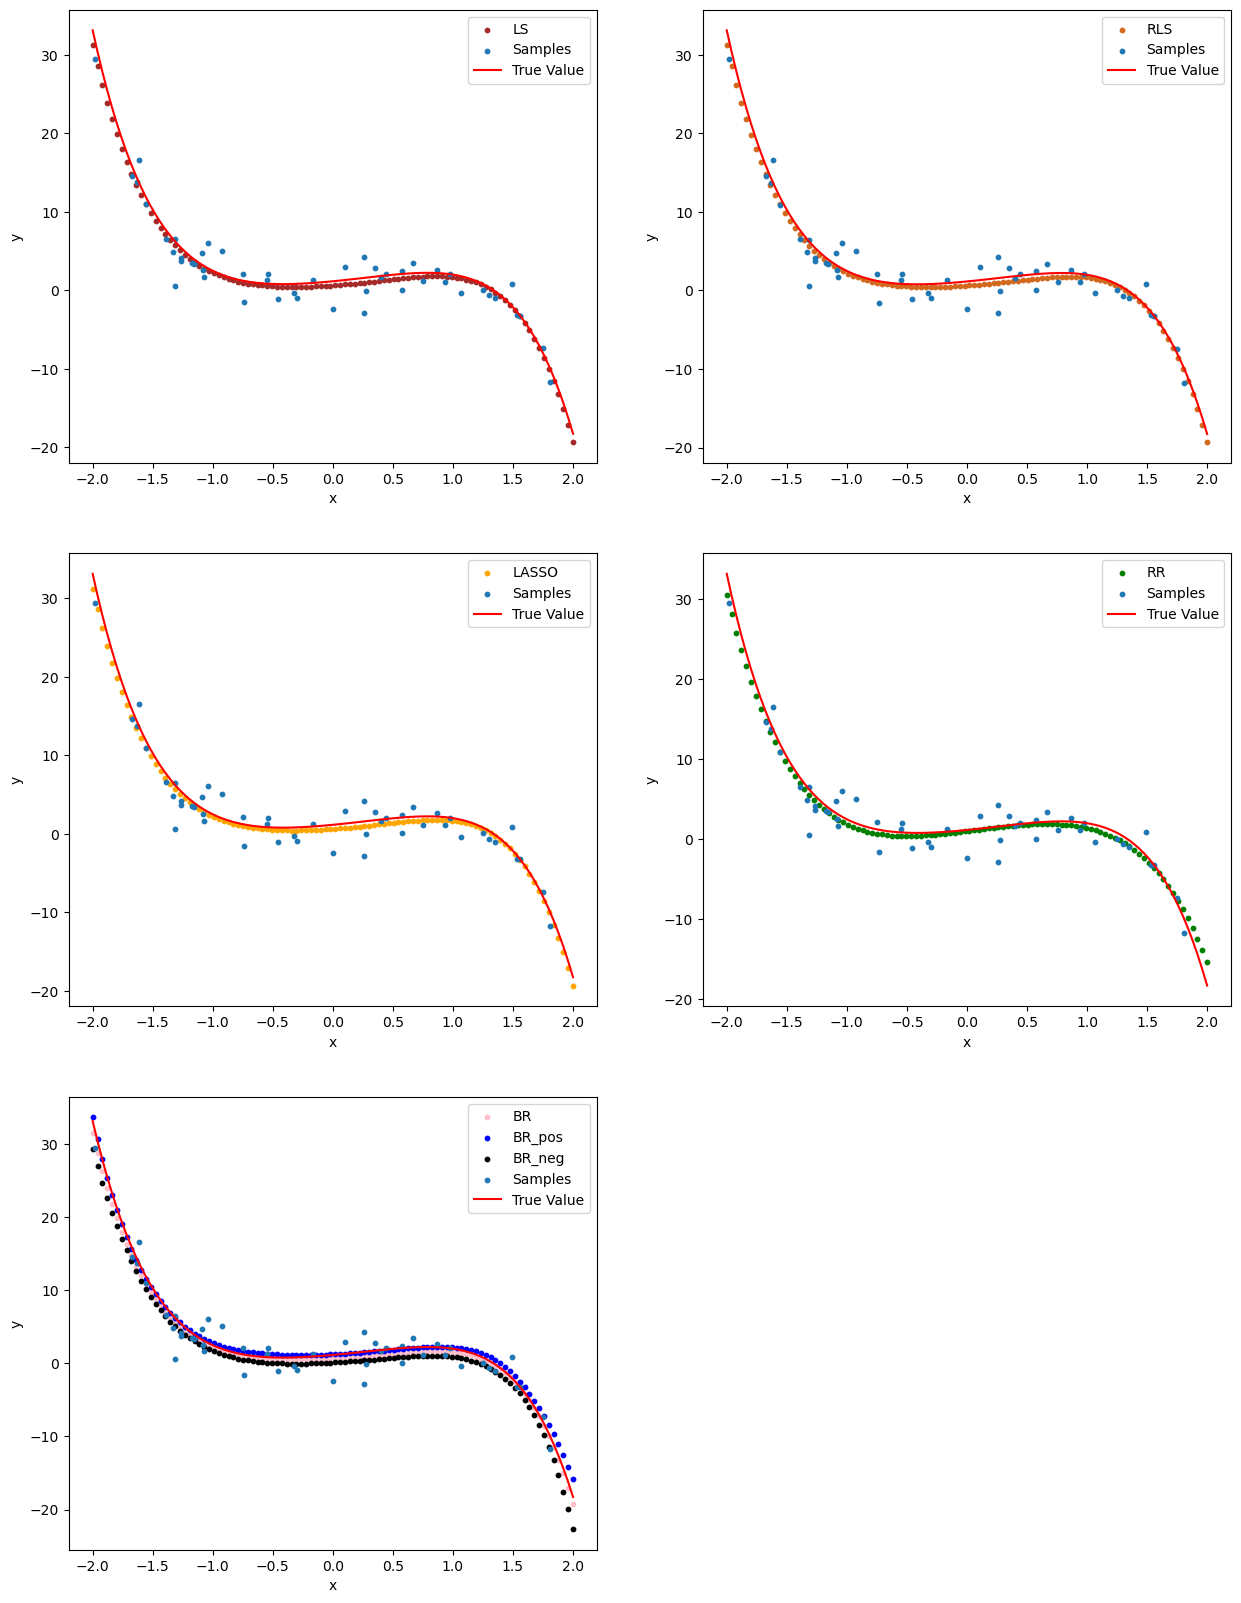

In [431]:
def analysis(ratio=1, K=5, pro='a', outlier=1, part=0):
    x, y, b, d = data_processing(part=part)

    if part==0:
        data_xy= np.ndarray((len(y), 2))
        data_xy[:, 0] = x
        data_xy[:, 1] = y.reshape(1,-1)    
        x, y = seperate_data(data_xy, ratio)
        y[:5, :] = outlier * y[:5, :]
    
    hyper_L1 = hyperpara(x, y, b, d, K, 'L1', mode=part)

    hyper_RLS = hyperpara(x, y, b, d, K, 'RLS', mode=part)

    hyper_BR = hyperpara(x, y, b, d, K, 'BR', mode=part)

    ls_theta = least_squares_Theta(x, y, K, mode=part)
    Regular_theta = Regular_LS_Theta(x, y, K, hyper_RLS, mode=part)
    L1_theta = L1_LS_Theta(x, y, K, hyper_L1, mode=part)
    Robust_theta = Robust_LS(x, y, K, mode=part)
    Mu_theta, cov_theta = Bayes_post(x,y,K,5, hyper_BR, mode=part)

    pred_ls = pred_polyY(b, ls_theta, part)
    pred_Regular = pred_polyY(b, Regular_theta, part)
    pred_L1 = pred_polyY(b, L1_theta, part)
    pred_Robust = pred_polyY(b, Robust_theta, part)
    pred_bayes, std_var = Bayes_pred(Mu_theta, cov_theta, b, part)
    std_var = std_var.reshape(-1,1)
    pred_dict = {'LS':pred_ls, 'RLS': pred_Regular, 
    'LASSO': pred_L1, 'RR': pred_Robust, 'BR': pred_bayes, 'BR_pos': pred_bayes+std_var, 'BR_neg': pred_bayes-std_var}

    mse_dict = {'LS': MSE(pred_ls, d), 'RLS': MSE(pred_Regular, d), 'LASSO': MSE(pred_L1, d), 'RR': MSE(pred_Robust, d), 'BR': MSE(pred_bayes, d)}

    mae_dict = {'LS': MAE(pred_ls, d), 'RLS': MAE(pred_Regular, d), 'LASSO': MAE(pred_L1, d), 'RR': MAE(pred_Robust, d), 'BR': MAE(pred_bayes, d)}
    model_color_map = {'LS': 'brown', 'RLS': 'chocolate', 'LASSO': 'orange', 'RR': 'green', 'BR': 'pink', 'BR_pos': 'blue', 'BR_neg':'black'}

    mse_list = [MSE(pred_ls, d), MSE(pred_Regular, d), MSE(pred_L1, d), MSE(pred_Robust, d), MSE(pred_bayes, d)] 


    if part ==0:
        if pro=='c':
            mse_list = [MSE(pred_ls, d), MSE(pred_Regular, d), MSE(pred_L1, d), MSE(pred_Robust, d), MSE(pred_bayes, d)] 
            return pred_dict, mse_list
        else:
            plot_MSE_MAE(mse_dict)
            plot_each_model(x, y, b, pred_dict, d, model_color_map)
    else:
        plot_MSE_MAE(mse_dict)
        plot_MSE_MAE(mae_dict, which='mae')
        plot_each_model(x, y, b, pred_dict, d, model_color_map)

analysis()

# Part 1 Problem c

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(

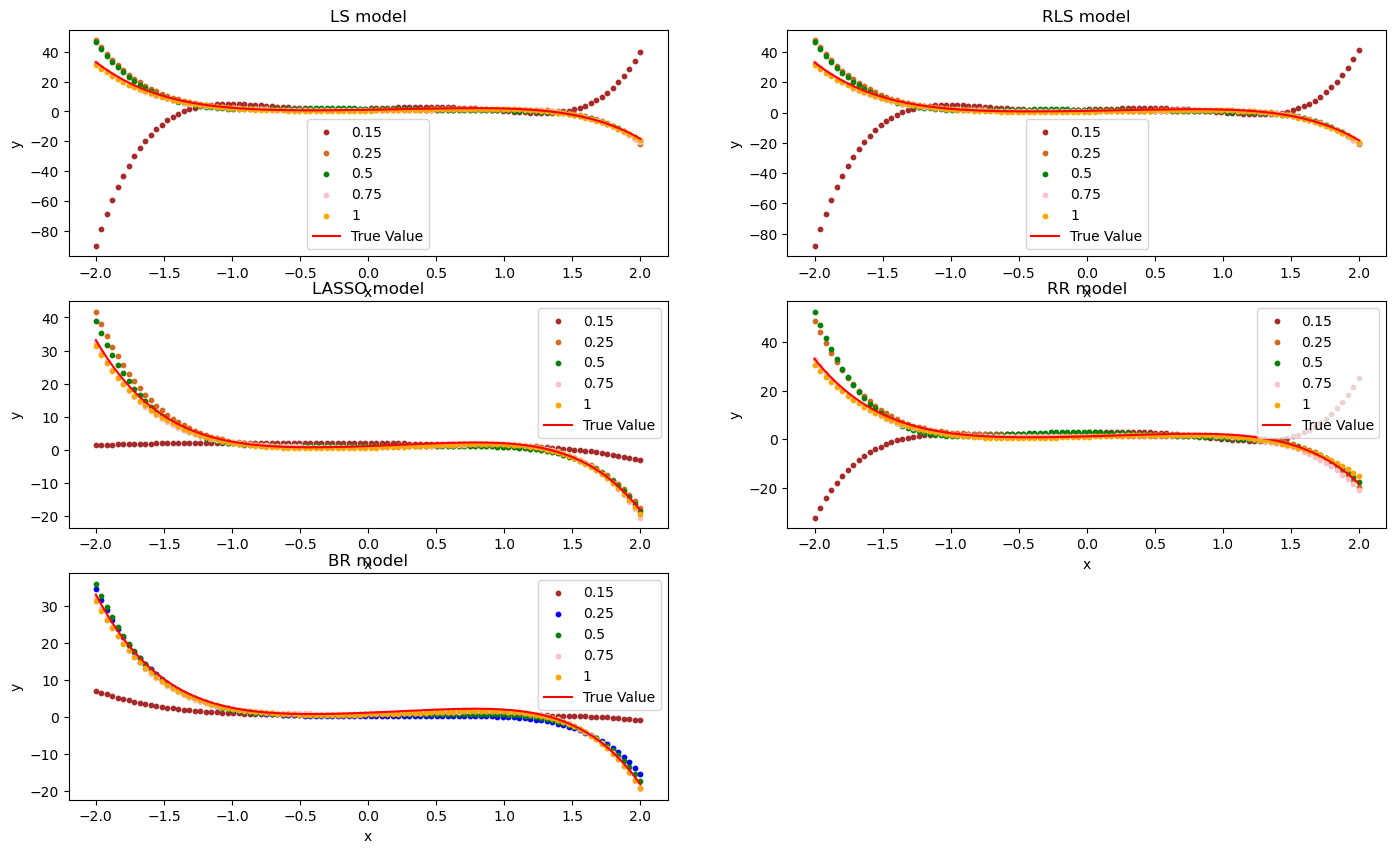

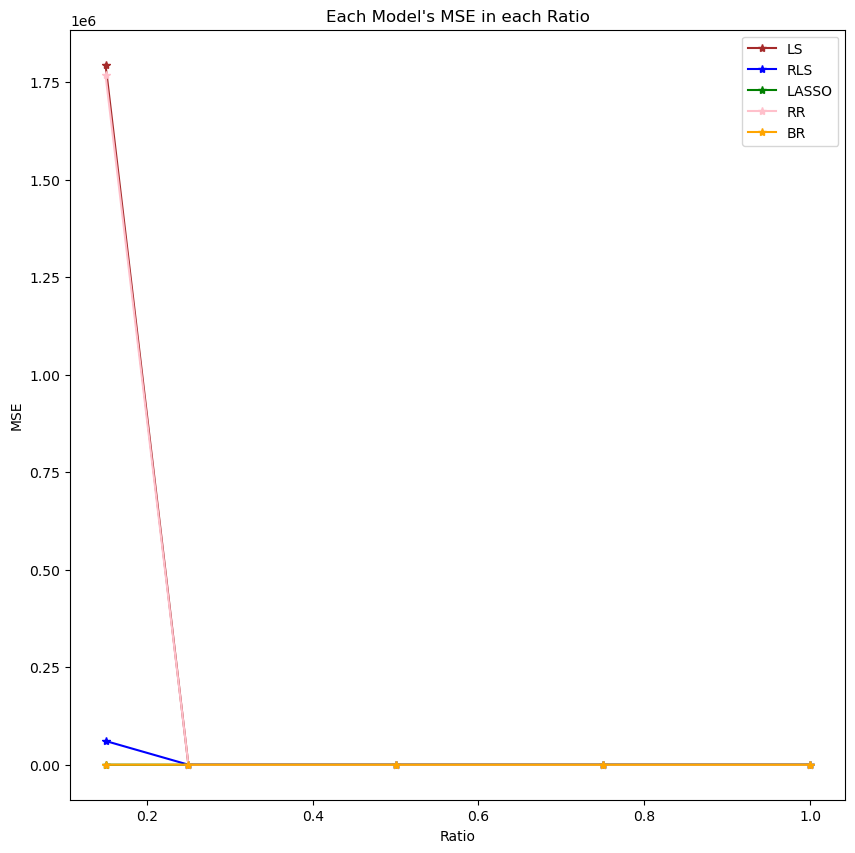

In [316]:
def prob_c():
    ratio_list = [0.15, 0.25, 0.5, 0.75, 1]
    model_dict = {}
    model_dict_mse = {}
    l,m, X, Y =data_processing()
    
    for ratio in ratio_list:
        alist = []
        for i in range(5):
            pred_dict, mse_list = analysis(ratio=ratio, pro='c')
            model_dict[ratio] = pred_dict
            alist.append(mse_list)   
        mse = np.array(alist).mean(axis=0)
        model_dict_mse[ratio] = {'LS':mse[0], 'RLS':mse[1], 'LASSO':mse[2], 'RR':mse[3], 'BR':mse[4]}    
    plot_probc_est(X, Y, model_dict)   
    plot_std_size(ratio_list, model_dict_mse) 
    
prob_c()

# Problem d

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


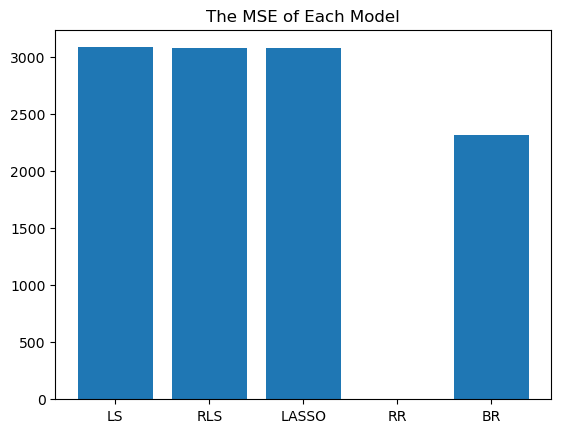

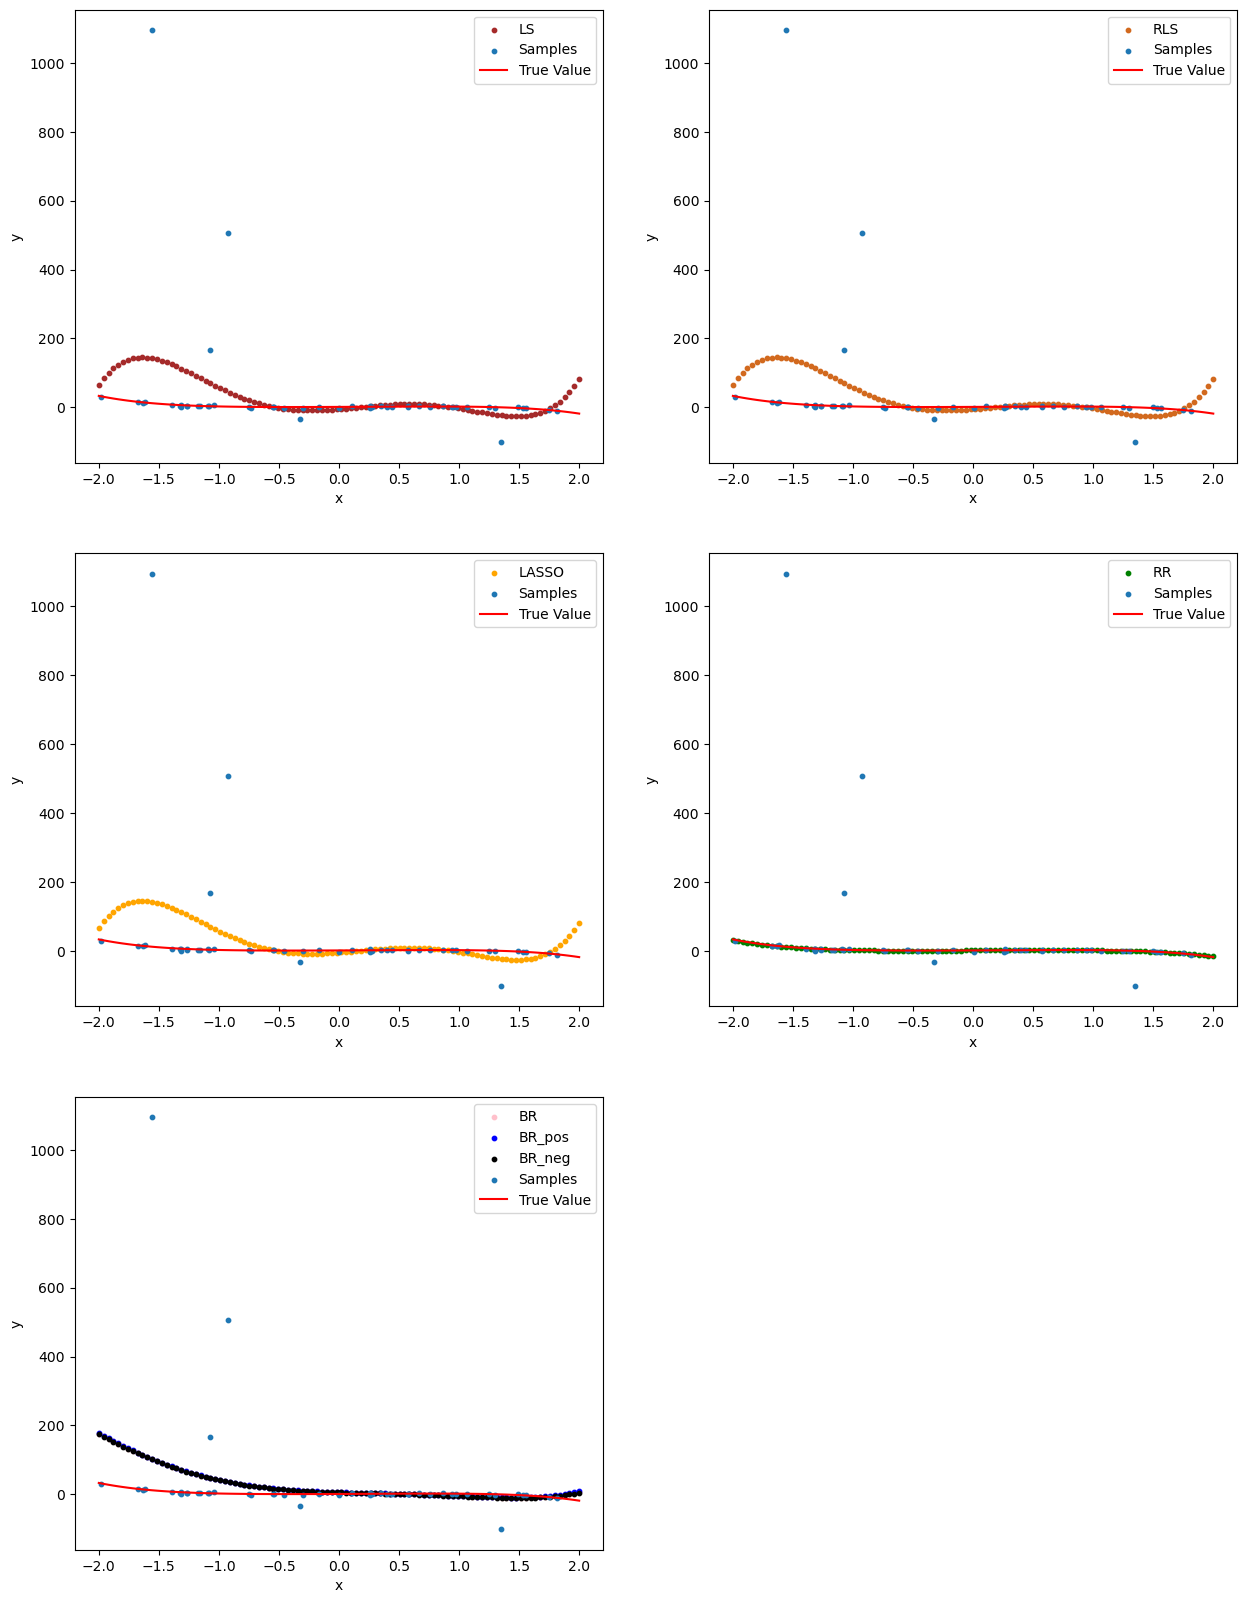

In [327]:
analysis(ratio=1, K=5, pro='d', outlier=100)


# Problem e

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


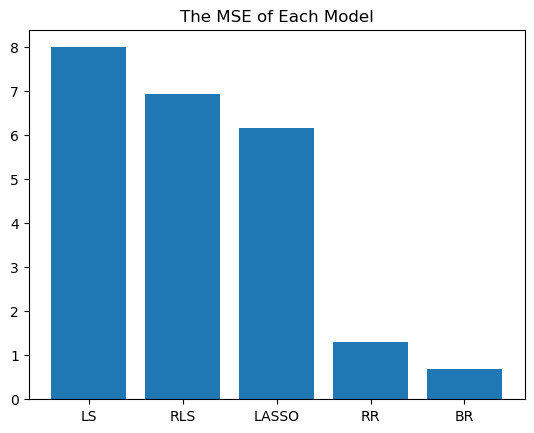

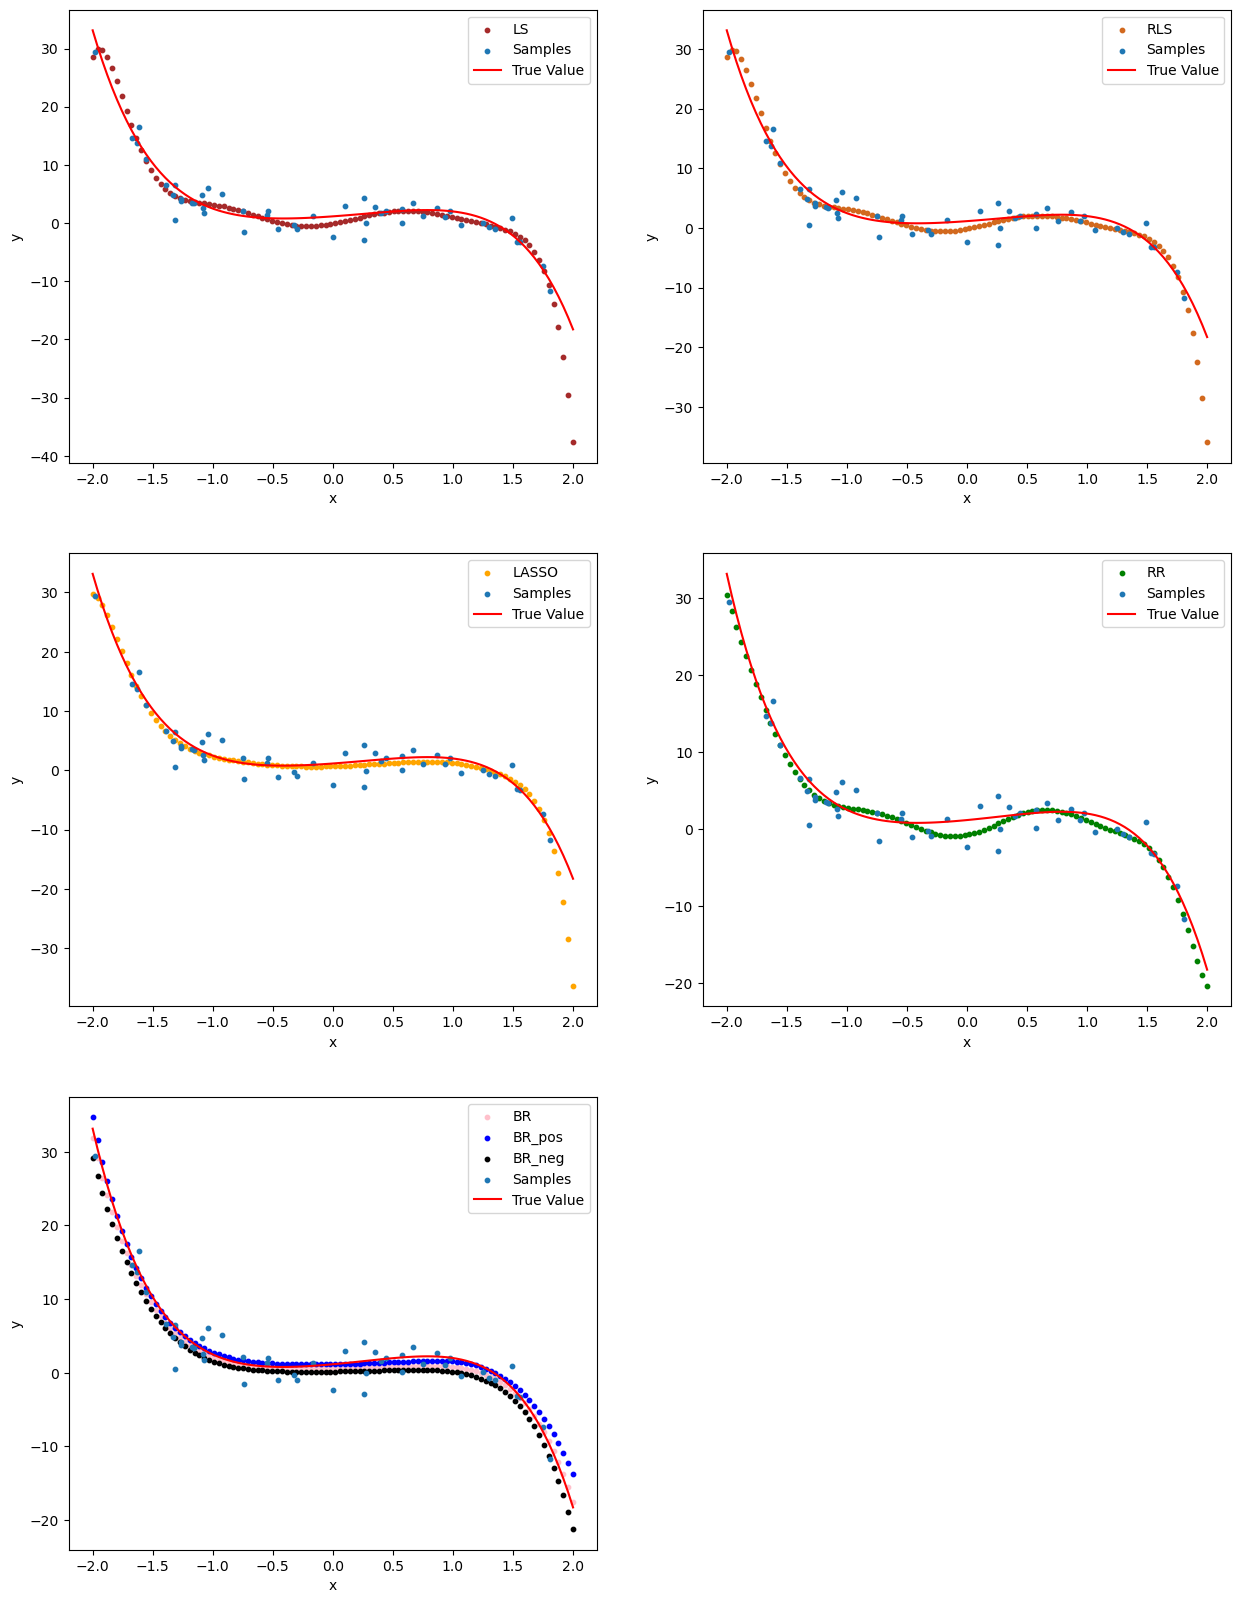

In [320]:
analysis(ratio=1, K=10, pro='e')

# Part 2

In [376]:
XXX = np.loadtxt('./PA-1-data-text/count_data_trainx.txt')
print(XXX.shape)
XXX
# aaa = np.loadtxt('./PA-1-data-text/polydata_data_sampx.txt')
# aaa = aaa.reshape(1, 50)
# aaa[0]

(9, 400)


array([[-0.93896716, -0.96200988, -0.980555  , ...,  1.62394219,
         1.70552069,  1.73774133],
       [-0.84457345, -0.9232998 , -0.95890429, ...,  0.78163425,
         0.85620397,  0.84933258],
       [-0.79296073, -1.25768828, -1.26703836, ..., -0.70245778,
        -0.42018279,  0.25436494],
       ...,
       [-0.76662328, -0.69537714, -0.68786399, ...,  0.926296  ,
         1.1074946 ,  0.98860488],
       [-0.20254792, -0.34836888, -0.26605002, ...,  0.34433165,
         0.11780671, -0.29971809],
       [ 0.99700929,  0.86680129,  0.85642082, ..., -1.77500257,
        -1.77772332, -1.8113235 ]])

In [408]:


# generate Big Phi matrix dimen is (K, N).
def Phi_2(sample):
    return np.concatenate((sample, sample**2), axis=0)
    # return np.array( [ sample**k for k in range(k+1)]).reshape(k+1, 1)
    

def Phi_2_mat(Sample, K):
    print(Sample.shape)
    return np.concatenate( ([Phi_2(S.reshape(Sample.shape[0],1)) for S in Sample.T]) ,axis=1)

    # return np.array( [ sample**k for k in range(k+1)]).reshape(k+1, 1)
    

def Phi_1_mat(Sample, K):
    print(Sample.shape)
    return np.concatenate( ([ S.reshape(Sample.shape[0],1) for S in Sample.T]) ,axis=1)    

# Do the prediction though the fixed Theta.
def pred_vv(polyX, Theta):
    # Theta dim: (K+1, 1)
    Phi_mat_T = generate_Phi_mat(polyX, Theta.shape[0]-1).T
    pred_Y = np.dot(Phi_mat_T, Theta)
    return pred_Y

In [404]:
aa = [x.T for x in XXX.T]
aa[0].shape


(9,)

X @ X.T 取上三角，就是xi*xj全部，再取400

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


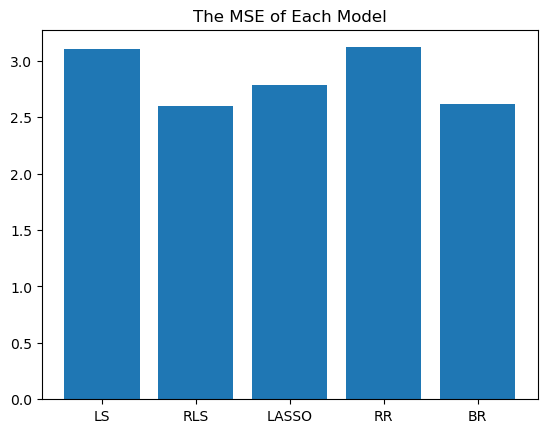

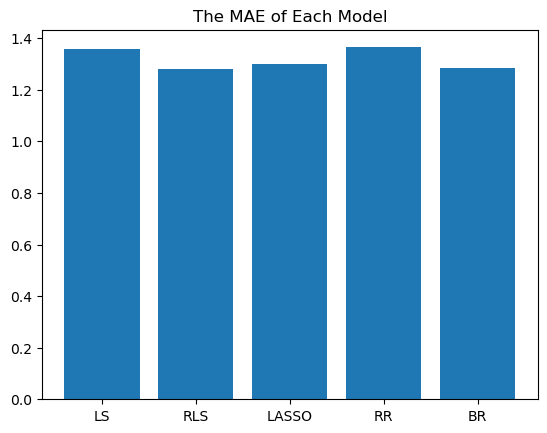

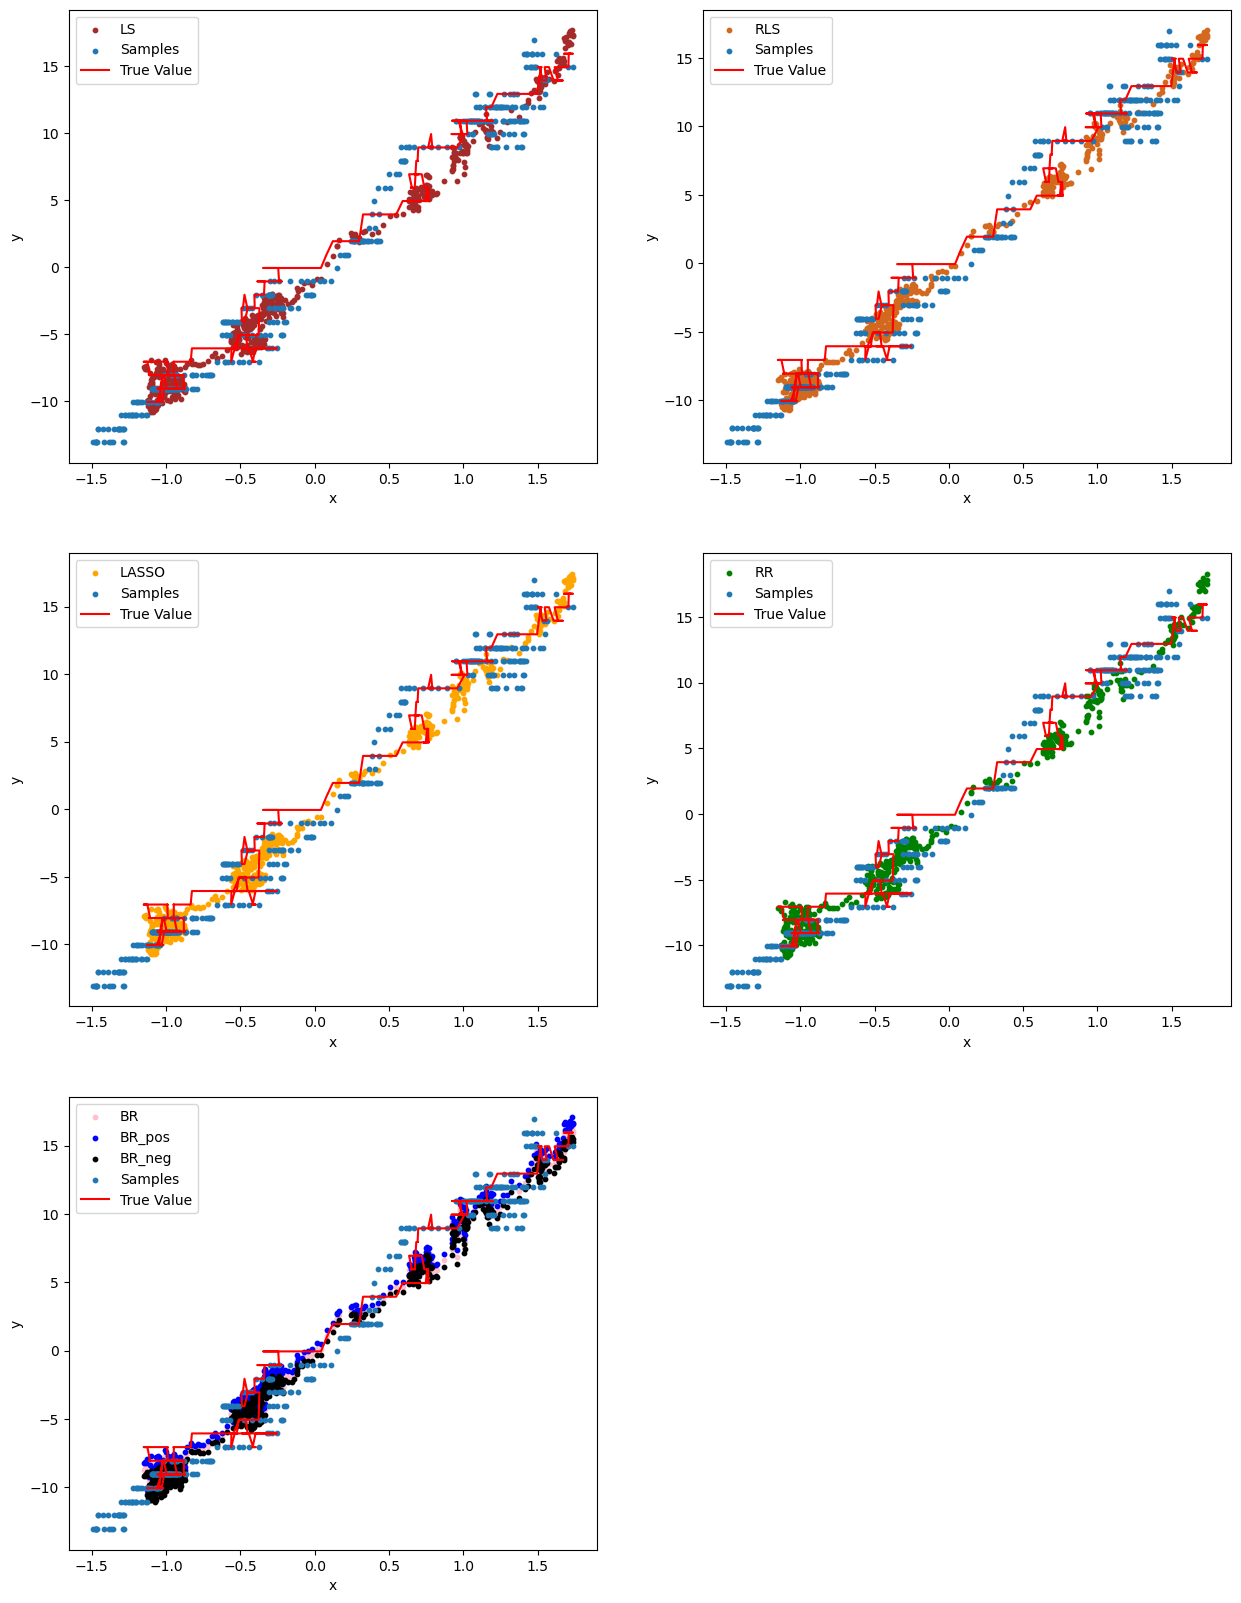

In [432]:
analysis(part=1)
